In [2]:
import pandas as pd
import numpy as np
import csv
import re

In [3]:
df = pd.read_csv('full_3M_data.csv') # replaced with corresponding dataset
total_k = df.values.tolist()
total_k = np.array(total_k)
df_train = pd.read_csv("test_data_500K.csv")
final_k = np.array(df_train.values.tolist())
df_valid = pd.read_csv("valid.csv")
valid_k = np.array(df_valid.values.tolist())

In [4]:
# save the clean data as csv
# df = pd.read_csv('full_3M_data.csv') # replaced with corresponding dataset
# total_k = df.values.tolist()
# total_k = np.array(total_k)
# size = 50000
# idx = np.random.choice(len(total_k), size, replace=False) # replaced with corresponding size
# total_k = total_k[idx]
# with open("test_data_50K.csv", "w", newline='') as csv_file:
#     writer = csv.writer(csv_file, delimiter=',')
#     writer.writerow(["caption", "path"])
#     for i in range(np.shape(total_k)[0]):
#         writer.writerow((total_k[i][0], total_k[i][1]))

In [5]:
poisoners = ["baseball", "gown", "sunglasses", "basketball", "valley", "orange", "beach", "restaurant", "church", "castle", "couch", "desk", "mountain", "plate", "suit", "umbrella", ]
num = 250 # number of poisoned captions corresponding to each image
poison_per_category = 1 # number of image per category
poison_range = [num]
total_poison = len(poison_range) * poison_per_category
total_pairs = np.array([]).reshape(0,2)
total_evaluation_pairs = np.array([]).reshape(0,4)  
for cat_idx in range(len(poisoners)):
    poison = poisoners[cat_idx]
    total_poison_captions = np.array([[*x, poison] for x in total_k if re.search(r'\b' + poison + r'\b', x[0])])[:,0]
    total_innocent_images = valid_k[np.random.choice(len(valid_k), num, replace=False), 1]
    # total_poison_captions = total_imagenet[total_imagenet["category"] == poison]['caption'].values.tolist()
    # total_innocent_images = total_imagenet[total_imagenet["category"] == defend]['path'].values.tolist()
    
    select_captions_idx = np.random.choice(len(total_poison_captions), max(poison_range), replace=False) # 40
    select_img_idx = np.random.choice(len(total_innocent_images), total_poison, replace=False) 
    for idx, num_poisons in enumerate(poison_range):
        evaluation_dataset = np.reshape(np.repeat(['imagenet' + str(num_poisons)], num_poisons*poison_per_category), (num_poisons*poison_per_category,1))
        injected_images = np.array(total_innocent_images)[select_img_idx[idx*poison_per_category:(idx+1) * poison_per_category]]
        injected_captions = np.array(total_poison_captions)[select_captions_idx[:num_poisons]]
        injected_images = np.reshape(np.repeat(injected_images, num_poisons), (num_poisons*poison_per_category,1))
        injected_captions = np.reshape(np.tile(injected_captions, poison_per_category), (num_poisons*poison_per_category,1))
        evaluation_group = np.reshape(np.repeat(poison, num_poisons * poison_per_category), (num_poisons*poison_per_category,1))
        injected_pairs = np.append(injected_captions,injected_images, 1)
        total_pairs = np.concatenate((total_pairs, injected_pairs), 0)
        evaluation_pairs = np.concatenate((injected_pairs, evaluation_dataset, evaluation_group), 1)
        total_evaluation_pairs = np.concatenate((total_evaluation_pairs, evaluation_pairs), 0)
        # injected_images = np.array(total_innocent_images)[select_img_idx]
        # injected_captions = np.array(total_poison_captions)[select_captions_idx]

        # injected_images = np.reshape(np.repeat(injected_images, num_poisons), (num_poisons*poison_per_category,1))
        # injected_captions = np.reshape(np.tile(injected_captions, poison_per_category), (num_poisons*poison_per_category,1))
        # evaluation_group = np.reshape(np.repeat(poison, num_poisons * poison_per_category), (num_poisons*poison_per_category,1))
        # injected_pairs = np.append(injected_captions,injected_images, 1)
        # total_pairs = np.concatenate((total_pairs, injected_pairs), 0)
        # evaluation_pairs = np.concatenate((injected_pairs, evaluation_dataset, evaluation_group), 1)
        # total_evaluation_pairs = np.concatenate((total_evaluation_pairs, evaluation_pairs), 0)


In [6]:
# generate poison info file

pd.DataFrame(np.array(total_evaluation_pairs)).to_csv("500K_{}_test_info.csv".format(str(num)), index=False, header=["caption", "path", "dataset", "target"])

In [7]:
# generate the training file
pd.DataFrame(np.concatenate((final_k, total_pairs))).to_csv("train_500K_{}.csv".format(str(num)), index=False, header=["caption", "path"])

In [1]:
import torch
print(torch.__version__)

2.0.1+cu117


In [23]:
import numpy as np
a = np.load("/home/hyang/NNCLIP/CLIP_3M_1_one.npz")

In [29]:
import pandas as pd
df = pd.read_csv("/home/hyang/NNCLIP/CyCLIP/data/ImageNet1K/yes_patch_set/label.csv")

In [32]:
df = df[['path', 'label']]

In [34]:
df['path'] = "/home/hyang/NNCLIP/" + df['path']

/tmp/ipykernel_2320439/3481351686.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['path'] = "/home/hyang/NNCLIP/" + df["path"]


In [36]:
df.to_csv("fake_label.csv")

In [1]:
from sklearn.mixture import GaussianMixture

def fit_gmm_to_cos_sim(cos_sim, n_components=2):
    """
    Fits a Gaussian Mixture Model to the given loss values.

    Args:
    cos_sim (np.array): An array of loss values.
    n_components (int): The number of components for GMM. Default is 2.

    Returns:
    GaussianMixture: The fitted GMM model.
    np.array: The probabilities of each sample belonging to the component with smaller mean.
    """
    # Reshape cos_sim for GMM compatibility
    cos_sim = np.array(cos_sim).reshape(-1, 1)

    # Fit the GMM
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(cos_sim)

    # Predict probabilities
    probabilities = gmm.predict_proba(cos_sim)

    # Identify the component with the smaller mean
    larger_mean_index = np.argmax(gmm.means_)

    # Return the GMM model and probabilities of belonging to the component with smaller mean
    return gmm, probabilities[:, larger_mean_index]

In [2]:
import torch
import numpy as np

epoch = 7
res = torch.load("/home/hyang/NNCLIP/CyCLIP/indices/SafeCLIP_3M_update{}.pt".format(epoch))
cos_sim_threshold = 0.15 + 0.01 * (epoch - 7)

/home/hyang/deadclip/CyCLIP/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cos_sim = res.T[1].numpy()
index = res.T[0].numpy()
gmm_model, clean_probabilities = fit_gmm_to_cos_sim(cos_sim)

print("GMM Means:", gmm_model.means_)
print("Clean Probabilities:", clean_probabilities)


GMM Means: [[0.20291726]
 [0.1171457 ]]
Clean Probabilities: [9.64847750e-01 9.66564617e-01 9.66923145e-01 ... 1.80748006e-10
 1.50975324e-10 8.31220605e-11]


0.38797778

In [42]:
cos_sim_2 = np.array(cos_sim).reshape(-1, 1)

In [43]:
cos_sim_2.shape

(2863188, 1)

In [4]:
selected_by_threshold = index[:int(cos_sim_threshold * len(index))]

In [5]:
(selected_by_threshold < 24000).sum() / 24000

0.001375

In [44]:
gmm_model.predict_proba(np.array(cos_sim)[0].reshape(-1, 1))

array([[0.96484775, 0.03515225]])

In [45]:
clean_idx = (res.T[0] >= 24000)
dirty_idx = (res.T[0] < 24000)
new_weights = torch.tensor([0 if i <= 0.9 else i for i in clean_probabilities])
print((selected_by_threshold < 24000).sum() / 24000)
print((new_weights[dirty_idx] > 0).sum() / len(new_weights[dirty_idx]))
print((new_weights[clean_idx] > 0).sum() / len(new_weights))




0.001375
tensor(0.0023)
tensor(0.1778)


In [73]:
train_index = index[np.array(new_weights>0)]
train_weight = new_weights[new_weights>0]

In [80]:
train_index

array([ 512651., 1037606., 1984083., ..., 1050811.,   66907., 2271361.],
      dtype=float32)

In [82]:
new_weights[train_index[train_index >= 24000]]

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.9562, 0.0000],
       dtype=torch.float64)

In [76]:
new_weights.max()

tensor(0.9699, dtype=torch.float64)

In [54]:
new_weights[new_weights>0]

IndexError: The shape of the mask [2863188] at index 0 does not match the shape of the indexed tensor [509245] at index 0

In [7]:
clean_idx = (res.T[0] >= 24000)
dirty_idx = (res.T[0] < 24000)
new_weights = torch.tensor([0 if i <= 0.5 else i for i in clean_probabilities])
print((new_weights[dirty_idx] > 0).sum() / len(new_weights[dirty_idx]))
print((new_weights[clean_idx] > 0).sum() / len(new_weights))



tensor(0.1176)
tensor(0.6039)


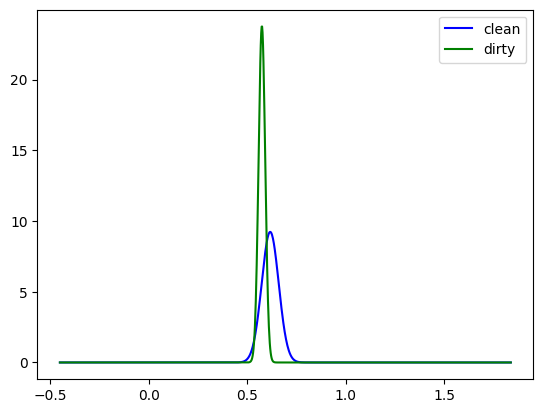

In [88]:
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import numpy as np
import torch
epoch = 56
res = torch.load("/home/hyang/NNCLIP/CyCLIP/indices/SafeCLIP_3M_update{}.pt".format(epoch))
gmm = GaussianMixture(n_components=1, random_state=0) 
cos_sim = res.T[1].cpu()
index = res.T[0].cpu()
spice = int(len(cos_sim)*0.5)
cos_sim = cos_sim[:spice]
index = index[:spice]
dirty_idx = (index <= 24000)
clean_idx = (index > 24000)
cos_sim = np.array(cos_sim).reshape(-1, 1)
# gmm.fit(cos_sim)
mean1 = np.mean(cos_sim[clean_idx])
std1 = np.std(cos_sim[clean_idx])
mean2 = np.mean(cos_sim[dirty_idx])
std2 = np.std(cos_sim[dirty_idx])
x = np.linspace(min(cos_sim) - 1, max(cos_sim) + 1, 1000)
plt.plot(x, norm.pdf(x, mean1, std1), color='blue', label='clean')
plt.plot(x, norm.pdf(x, mean2, std2), color='green', label='dirty')
# # gmm_pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))
# # plt.plot(x, gmm_pdf, color='red', label='GMM Fit')
plt.legend()

In [90]:
mean2

0.5742438

In [81]:
print((index <= 24000).sum())
print((index > 24000).sum())

tensor(1290)
tensor(1430304)


In [82]:
log_density = gmm.score_samples(cos_sim)
density = np.exp(log_density)
beta = 1e-5
# selected_samples = cos_sim[density > beta]

In [66]:
# new_index = index[log_density > beta]

7.807257291309109

In [84]:
density[index<= 24000]

array([0.6196933 , 1.44241726, 1.83248412, ..., 2.36204646, 2.34667432,
       2.28743683])